In [2]:
import numpy as np
from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import fetch_miyawaki2008
import pylab as plt
from tqdm import tqdm
path_data = op.abspath('./data/')
%matplotlib inline


# About this tutorial
This example is also drawn from the `nilearn` docs. You can find the original [here](https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html#sphx-glr-auto-examples-02-decoding-plot-miyawaki-encoding-py).

This example partly reproduces the encoding model presented in
> [Visual image reconstruction from human brain activity
    using a combination of multiscale local image decoders](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6),
    Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A.,
    Morito, Y., Tanabe, H. C., ... & Kamitani, Y. (2008).
    Neuron, 60(5), 915-929.


# Encoding models for visual stimuli

Encoding models try to predict neuronal activity using information from
presented stimuli, like an image or sound. Where decoding goes from
brain data to real-world stimulus, encoding goes the other direction.

We demonstrate how to build such an **encoding model** in nilearn, predicting
**fMRI data** from **visual stimuli**, using the dataset from
[Miyawaki et al., 2008](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6>).

Participants were shown images, which consisted of random 10x10 binary
(either black or white) pixels, and the corresponding fMRI activity was
recorded. We will try to predict the activity in each voxel
from the binary pixel-values of the presented images. Then we extract the
receptive fields for a set of voxels to see which pixel location a voxel
is most sensitive to.

Loading the data
----------------
Now we can load the data set:



In [17]:
dataset = fetch_miyawaki2008(data_dir=path_data)

We only use the training data of this study,
where random binary images were shown.



In [4]:
# training data starts after the first 12 files
fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

We can use `nilearn.input_data.MultiNiftiMasker` to load the fMRI
data, clean and mask it.

In [5]:
masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

# shape of the binary (i.e. black and wihte values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli = []
for stimulus_run in stimuli_random_runs_filenames:
    stimuli.append(np.reshape(np.loadtxt(stimulus_run,
                              dtype=np.int, delimiter=','),
                              (-1,) + stimulus_shape, order='F'))

Let's take a look at some of these binary images:



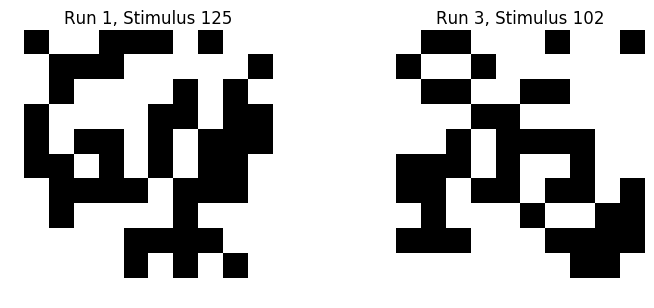

In [6]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(stimuli[0][124], interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title('Run {}, Stimulus {}'.format(1, 125))
plt.subplot(1, 2, 2)
plt.imshow(stimuli[2][101], interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title('Run {}, Stimulus {}'.format(3, 102))
plt.subplots_adjust(wspace=0.5)

We now stack the fmri and stimulus data and remove an offset in the
beginning/end.



In [7]:
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(float)

fmri_data is a matrix of *samples* x *voxels*



In [8]:
print(fmri_data.shape)

(2860, 5438)


We flatten the last two dimensions of stimuli
so it is a matrix of *samples* x *pixels*.



In [9]:
# Flatten the stimuli
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

print(stimuli.shape)

(2860, 100)


Building the encoding models
----------------------------
We can now proceed to build a simple **voxel-wise encoding model** using
`Ridge regression <http://en.wikipedia.org/wiki/Tikhonov_regularization>`_.
For each voxel we fit an independent regression model,
using the pixel-values of the visual stimuli to predict the neuronal
activity in this voxel.



In [10]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using 10-fold cross-validation, we partition the data into 10 'folds'.
We hold out each fold of the data for testing, then fit a ridge regression
to the remaining 9/10 of the data, using stimuli as predictors
and fmri_data as targets, and create predictions for the held-out 10th.



In [11]:
from sklearn.metrics import r2_score

estimator = Ridge(alpha=100.)
cv = KFold(len(stimuli), 10)

scores = []
for train, test in tqdm(cv):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = Ridge(alpha=100.).fit(
    stimuli.reshape(-1, 100)[train], fmri_data[train]).predict(
        stimuli.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(fmri_data[test], predictions,
                           multioutput='raw_values'))

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Mapping the encoding scores on the brain
----------------------------------------
To plot the scores onto the brain, we create a Nifti1Image containing
the scores and then threshold it:



In [12]:
from nilearn.image import threshold_img
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6)

Plotting the statistical map on a background brain, we mark four voxels
which we will inspect more closely later on.



/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


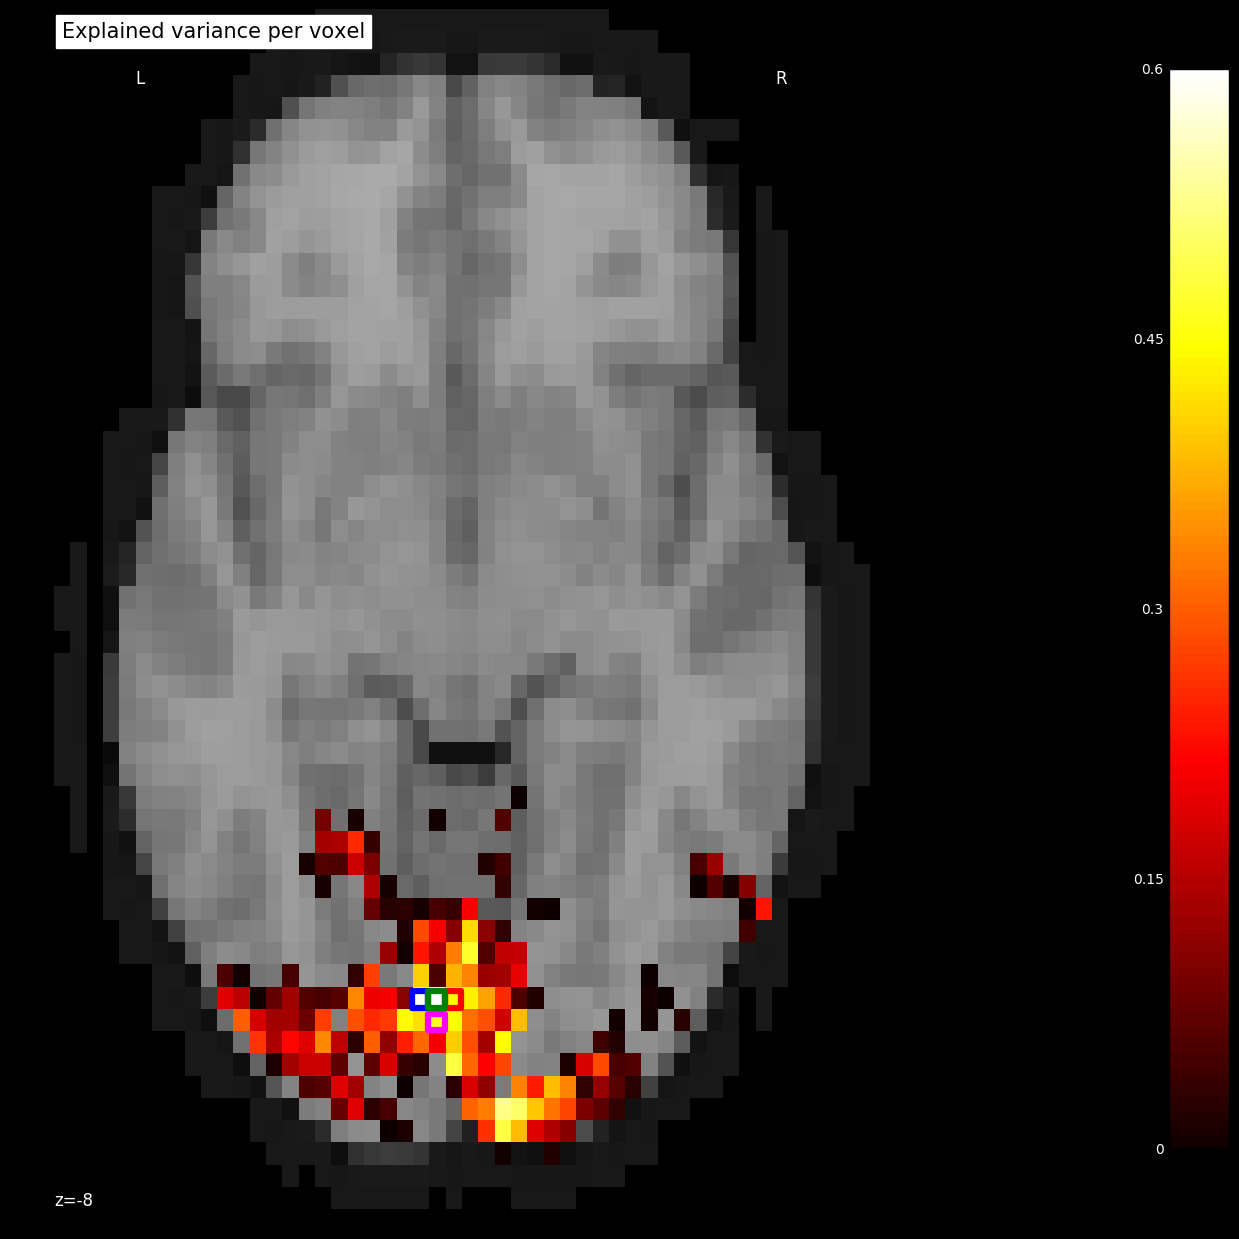

In [13]:
from nilearn.plotting import plot_stat_map
from nilearn.image.resampling import coord_transform

def index_to_xy_coord(x, y, z=10):
    '''Transforms data index to coordinates of the background + offset'''
    coords = coord_transform(x, y, z,
                             affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z', aspect=1.25,
                        title='Explained variance per voxel')

# creating a marker for each voxel and adding it to the statistical map

for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(index_to_xy_coord(x, y), marker_color='none',
                        edgecolor=['b', 'r', 'magenta', 'g'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)


# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(12, 12)

Estimating receptive fields
---------------------------
Now we take a closer look at the receptive fields of the four marked voxels.
A voxel's `receptive field <http://en.wikipedia.org/wiki/Receptive_field>`_
is the region of a stimulus (like an image) where the presence of an object,
like a white instead of a black pixel, results in a change in activity
in the voxel. In our case the receptive field is just the vector of 100
regression  coefficients (one for each pixel) reshaped into the 10x10
form of the original images. Some voxels are receptive to only very few
pixels, so we use `Lasso regression
<http://en.wikipedia.org/wiki/Lasso_(statistics)>`_ to estimate a sparse
set of regression coefficients.



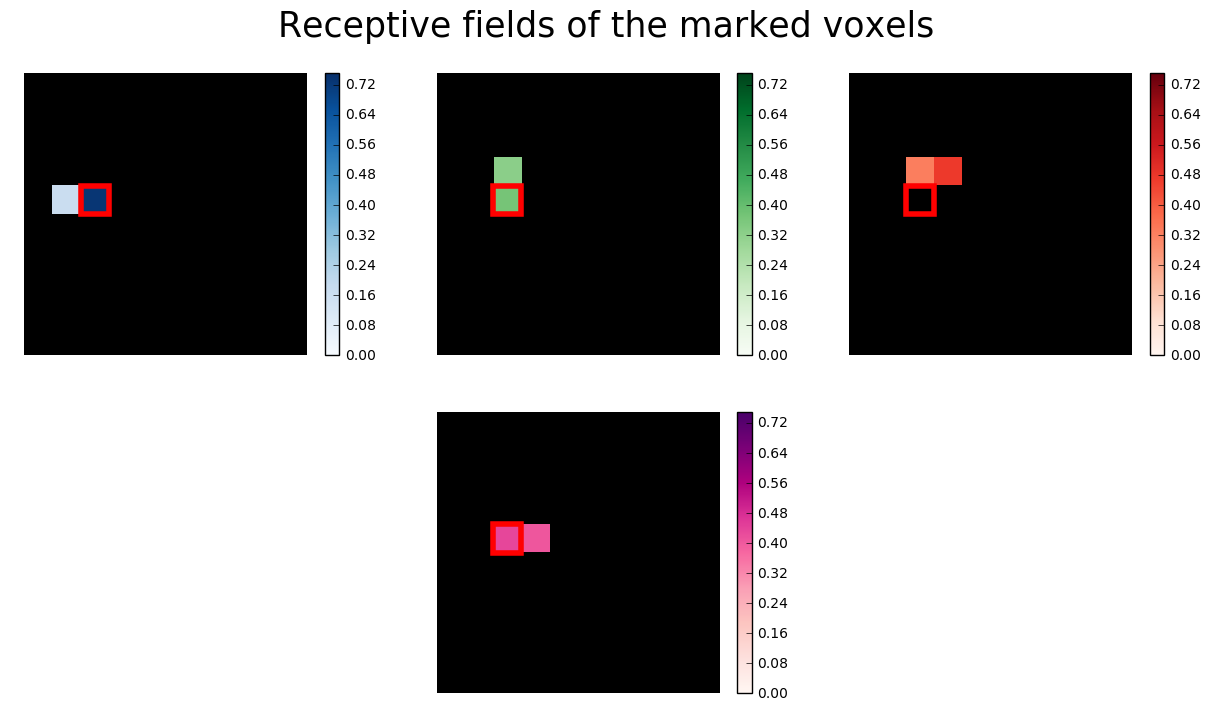

In [14]:
from sklearn.linear_model import LassoLarsCV

# automatically estimate the sparsity by cross-validation
lasso = LassoLarsCV(max_iter=10)

# Mark the same pixel in each receptive field
marked_pixel = (4, 2)

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the marked voxels', fontsize=25)

# GridSpec allows us to do subplots with more control of the spacing
gs1 = gridspec.GridSpec(2, 3)

# we fit the Lasso for each of the three voxels of the upper row
for i, index in enumerate([1780, 1951, 2131]):
    ax = plt.subplot(gs1[0, i])
    # we reshape the coefficients into the form of the original images
    rf = lasso.fit(stimuli, fmri_data[:, index]).coef_.reshape((10, 10))
    # add a black background
    ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
    ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                      cmap=['Blues', 'Greens', 'Reds'][i], vmin=0., vmax=0.75)
    # add the marked pixel
    ax.add_patch(Rectangle(
        (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
        facecolor='none', edgecolor='r', lw=4))
    plt.axis('off')
    plt.colorbar(ax_im, ax=ax)

# and then for the voxel at the bottom

gs1.update(left=0., right=1., wspace=0.1)
ax = plt.subplot(gs1[1, 1])
# we reshape the coefficients into the form of the original images
rf = lasso.fit(stimuli, fmri_data[:, 1935]).coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='RdPu', vmin=0., vmax=0.75)

# add the marked pixel
ax.add_patch(Rectangle(
    (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
    facecolor='none', edgecolor='r', lw=4))
plt.axis('off')
plt.colorbar(ax_im, ax=ax)

The receptive fields of the four voxels are not only close to each other,
the relative location of the pixel each voxel is most sensitive to
roughly maps to the relative location of the voxels to each other.
We can see a relationship between some voxel's receptive field and
its location in the brain.

